## Library

In [2]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Estimation parameters

# Clean Data

### Inflation rate (1947:Q1 - 2024:Q4)
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### Markup (1947:Q1 - 2017:Q4)
The Cyclical Behavior of the Price-Cost Markup

Christopher J. Nekarda (Board of Governors of the Federal Reserve System)

Valerie A. Ramey (University of California, San Diego and NBER)

paper: https://econweb.ucsd.edu/~vramey/research/markupcyc.pdf

data: https://econweb.ucsd.edu/~vramey/research.html

### Output and Output gap (1947:Q1 - 2024:Q4) 
- Output: GDPC1 (https://fred.stlouisfed.org/series/GDPC1)

- Output gap : Beveridge-Nelson Filter's cycle component of GDPC1 (https://bnfiltering.com)

### Inflation Expectation (1982Q1-2024)
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)

### The number of Firm  (inverse of HHI)
- HHI World Integrated Trade Solution (WITS) of the World Bank

(https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/HH-MKT-CNCNTRTN-NDX#)

quarterly HHI data obtained by linear interpolation of the original annual series

or

- Business Employment Dynamics (https://db.nomics.world/BLS/bd?tab=list)

quarterly log of the number of firm data obtained by linear interpolation of the original annual series and

---
$\pi_{t}$ : Inflation rate = ($\frac{\text{CPI}_{t} - \text{CPI}_{t-1}}{\text{CPI}_{t-1}}$)

$E_t[\hat{\pi}_{t+1}]$ : Quarterly Infration Expectation = $\frac{\text{one year inflation expectation}}{4}$

$\hat{Y}_t$ : Output gap = 100 * cycle of the Real Gross Domestic Product (GDPC1) in US (from BN filter)

$N_{t}$ : the number of establishments = log of (the number of establishments in US * 0.01)

or 

$N_{t}$ : the number of establishments = $1/HHI_t$

---

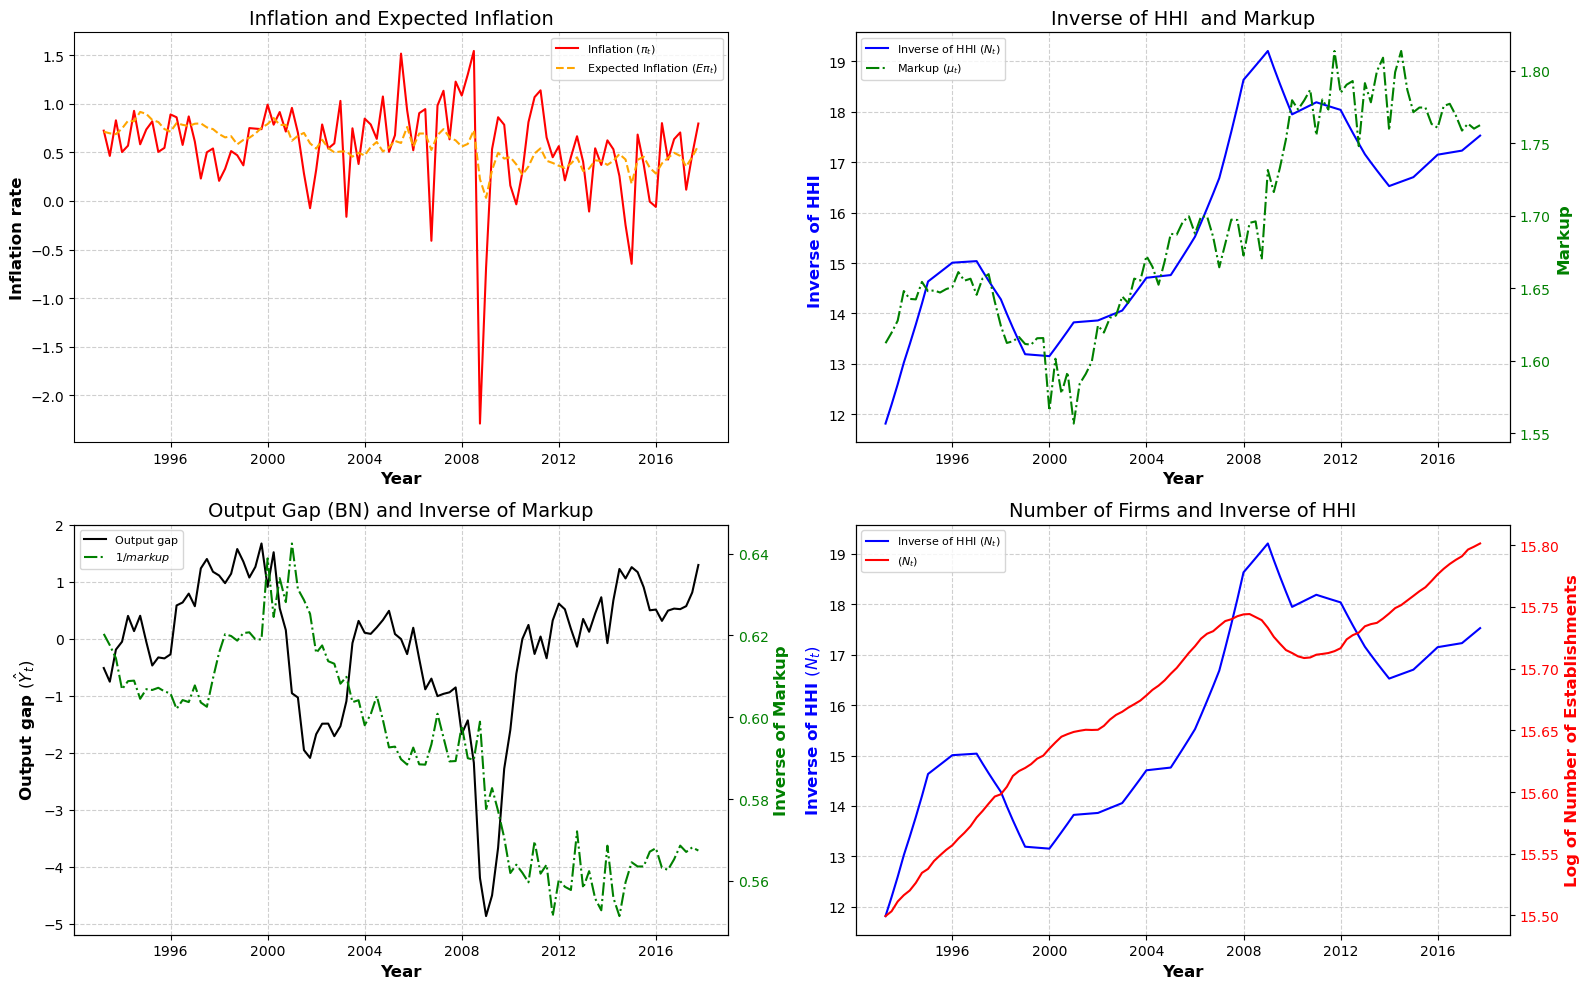

In [3]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = (1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)


data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat_BN'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["N_trend_BN"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat_BN", "N_trend_BN"]]

# # data_N
# data_Nb = pd.read_csv("data/BDSTIMESERIES.BDSGEO-2025-02-26T120133.csv")
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]]
# data_Nb['year'] = pd.to_datetime(data_Nb['Year (time)'], format='%Y') + pd.offsets.YearBegin(0)
# data_Nb = data_Nb.set_index('year')
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]].copy()
# data_Nb["N"] = pd.to_numeric(data_Nb["Number of firms (FIRM)"].str.replace(",", ""), errors="coerce")
# data_Nb = data_Nb.resample('QS').asfreq()
# data_Nb['Nb'] = np.log(data_Nb['N'].interpolate(method='linear'))
# data_Nb = data_Nb.reset_index()
# data_Nb['DATE'] = pd.to_datetime(data_Nb['year'])
# data_Nb = data_Nb[["DATE", "Nb"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_Nb = pd.merge(data_Nb, data_Nd, on = "DATE")
data_Nb = data_Nb.dropna()
data_Nb["Nchange"] = data_Nb["Nb"] - data_Nb["Nd"]
data_Nb = data_Nb[data_Nb["DATE"] >= "1993-04-01"]
initial_value = 5387024
data_Nb["Nb"] = initial_value + data_Nb["Nchange"].shift(fill_value=0).cumsum()
data_Nb["Nb"] = np.log(data_Nb["Nb"])
data_Nb = data_Nb[["DATE", "Nb"]]

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_Nb, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data = data.dropna()


# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
# Nb = jnp.array(data['Nb'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)

x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_outputgap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev = jnp.array(data['output_gap_prev'],dtype=jnp.float64)
x_markup_prev = jnp.array(1/data['markup_prev'],dtype=jnp.float64)

# N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)


# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1 = axs[0, 0]
ax1.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')
ax1.set_xlabel('Year', fontsize=12, weight='bold')
ax1.set_ylabel('Inflation rate', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Inflation and Expected Inflation', fontsize=14)
ax1.legend(fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('Inverse of HHI ', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3. Output Gap and Inverse Markup ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax3_right.plot(data["DATE"], 1 / data["markup"], label=r'$1/markup$', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel(r'Output gap $(\hat{Y}_t)$', fontsize=12, weight='bold')
ax3_right.set_ylabel('Inverse of Markup', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Output Gap (BN) and Inverse of Markup', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 4. Inverse HHI and Nb ---
ax4 = axs[1, 1]
ax4_left = ax4
ax4_right = ax4_left.twinx()
ax4_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax4_right.plot(data["DATE"], data["Nb"], label=r'$(N_{t})$', color='red')
ax4_left.set_xlabel('Year', fontsize=12, weight='bold')
ax4_left.set_ylabel(r'Inverse of HHI $(N_{t})$', fontsize=12, weight='bold', color='blue')
ax4_right.set_ylabel('Log of Number of Establishments', fontsize=12, weight='bold', color='red')
ax4_right.tick_params(axis='y', labelcolor='red')
ax4_left.grid(True, linestyle='--', alpha=0.6)
ax4_left.set_title('Number of Firms and Inverse of HHI', fontsize=14)
lines = ax4_left.get_lines() + ax4_right.get_lines()
labels = [line.get_label() for line in lines]
ax4_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()

## Estimation

NKPC under HSA

Rotemberg

$$
\hat{\pi}_{t}=\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\pi}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\zeta\left(z\right)-1}{\chi}}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)-\overset{\text{dynamic effect}}{\overbrace{\frac{1}{\chi}\frac{1-\rho\left(z\right)}{\rho\left(z\right)}\hat{N}_{t}}}
$$


Calvo
$$
\hat{\tilde{\pi}}_{t}	=	\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\tilde{\pi}}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\rho\left(\tilde{z}\right)}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{\tilde{p}}_{t}\right)
		-\overset{\text{dynamic effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\left(1-\rho\left(\tilde{z}\right)\right)\hat{N}_{t}}}.
$$
Note that $s\left(z_{t}\right)=\frac{1}{N_{t}}$.

Estimation strategy

$N_{t}$ denotes the measure of the number of firms (varieties), or the inverse of concentration, and $x_{t}$ denotes the measure of the output gap or the inverse of the markup.


# Prior distribution
| NKPC Parameters      | | 
|--------------- |--------------------|
| **$\alpha$**      | Uniform&nbsp;(0, 1) | 
|**$\kappa$**      | Uniform&nbsp;(0, 1) | 
|**$\theta$**      | Uniform&nbsp;(0, 1) | 
|**$\sigma_v$**    | LogNormal&nbsp;(0, 1) |

| AR Parameters | Prior / Definition | Notes |
|-----------|--------------------|-------|
| **$r_{\hat{N}}$** , **$r_{\hat{x}}$**    | Uniform&nbsp;(-1,&nbsp;1) | Magnitude of complex root for AR(2) |
| **$p_{\hat{N}}$** , **$p_{\hat{x}}$**     | Uniform&nbsp;(0.1,&nbsp;0.9) | Phase (fraction of π) for AR(2) |

| $\hat{N}$ Parameters      | | $\hat{N}$ hat with z Parameters| | $\hat{x}$ Parameters      | |
|--------------- |--------------------| --------------- |--------------------|--------------- |--------------------| 
| **$\rho_1$**     | $2r_{\hat{N}}cos(π p_{\hat{N}})$ |  **$\theta_{N,1}$**    | $2r_{\hat{N}}cos(π p_{\hat{N}})$ |**$\nu_1$**     |  $2r_{\hat{x}}cos(π p_{\hat{x}})$|  
|**$\rho_2$**      | $-r_{\hat{N}}^2$ |  **$\theta_{N,2}$**    | $-r_{\hat{N}}^2$ |**$\nu_2$**      | $-r_{\hat{x}}^2$ |  
|**$\delta$**      | Normal&nbsp;(0, 0.5) |  **$\theta_{\pi}$**    | Normal&nbsp;(0, 0.5) |**$\sigma$**      | Normal&nbsp;(0, 0.5) | 
|**$\phi$**      | Uniform&nbsp;(0, 1) | **$\theta_{x}$**    | Uniform&nbsp;(0, 1) |**$\beta$**      | Uniform&nbsp;(0, 1) |
|**$\sigma_u$**    | LogNormal&nbsp;(0, 0.1) |**$\sigma_u$**    | LogNormal&nbsp;(0, 0.1) |**$\sigma_\omega$**    | LogNormal&nbsp;(0, 0.1) |

| $\bar{N}$ Parameters      | |$\bar{y}$ Parameters      | | 
|--------------- |--------------------| --------------- |--------------------|
| **n**     | Normal&nbsp;(0, 0.5) |   **g**     | Normal&nbsp;(0, 0.5) |
|**$\sigma_\epsilon$**    | LogNormal&nbsp;(0, 1) |  **$\sigma_\chi$**    | LogNormal&nbsp;(0, 1) |

| $\kappa$ Parameters      | |
|--------------- |--------------------|
| **$\eta$**     | Uniform&nbsp;(0, 1) |
| **$\psi$**     | Uniform&nbsp;(0, 1) |
| **$\sigma_\mu$**     | LogNormal&nbsp;(0, 1) |

In [4]:
warmup= 5000
samples=20000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Uniform(0,1), 
        "kappa"      : dist.Uniform(0,1), 
        "theta"      : dist.Uniform(0,1), 

        # z params
        "theta_z"    : dist.Uniform(0,1), 
        "theta_N"    : dist.Uniform(0,1), 
        "theta_pi"   : dist.Normal(0, 1), 
        "theta_x"    : dist.Uniform(0,1), 
        
        # hat params
        "delta"      : dist.Normal(0, 1), 
        "psi"        : dist.Uniform(0,1), 
        # with z
        "sigma"      : dist.Normal(0, 1),
        "beta"       : dist.Normal(0, 1),
        
        # kappa params
        "phi"        : dist.Normal(0, 1),
        "eta"        : dist.Uniform(0,1), 
        # bar params 
        "n"          : dist.Uniform(0,1), 
        "g"          : dist.Uniform(0,1), 
        # initial
        "z_init"     : dist.Normal(0.5, 1), 
        "kappa_init" : dist.Normal(0.5, 1), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0,1),  
        "sigma_eps"  : dist.LogNormal(0,1),  
        "sigma_omega": dist.LogNormal(0,1),  
        "sigma_chi"  : dist.LogNormal(0,1),  
        "sigma_v"    : dist.LogNormal(0,1),
        "sigma_mu"   : dist.LogNormal(0,1),
        "sigma_e"    : dist.LogNormal(0,1),  
    }
    return priors

# Model to be estimated
---
Normal NKPC
$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa x_{t}+v_{t},
$$

In [5]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

In [6]:
# Normal NKPC
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup)
idata_0_m = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_kappa_m = posterior_samples["kappa"].mean()
model_0_alpha_m = posterior_samples["alpha"].mean()
diverging  = idata_0_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                           # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")            # bool for each param


# Normal NKPC
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_outputgap)
idata_0_bn = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_kappa_bn = posterior_samples["kappa"].mean()
model_0_alpha_bn = posterior_samples["alpha"].mean()
diverging  = idata_0_bn.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                           # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")            # bool for each param

sample: 100%|██████████| 25000/25000 [00:03<00:00, 7589.37it/s, 15 steps of size 1.48e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 25000/25000 [00:05<00:00, 4781.52it/s, 15 steps of size 1.31e-01. acc. prob=0.99]

model 0: divergence ratio = 0.0000%


---
No shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa x_{t}-\theta\hat{N}_{t}+v_{t},
$$
where
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\delta\pi_{t-1}+\phi x_{t-1}+u_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\varepsilon_{t},
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)  \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),
$$

In [7]:
def model_1(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    
    phi = numpyro.sample("phi", priors["phi"])
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .1))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .1))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2 + delta * pi_prev[t] + phi * x_prev[t]
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

---
Shift in the slope

$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t},
$$

where
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
$$\hat{N}_{t}=\rho_1\hat{N}_{t-1}+\rho_2\hat{N}_{t-2}+\delta\pi_{t-1}+\phi x_{t-1}+u_{t},
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\varepsilon_{t},
$$
$$
\kappa_{t}=\eta\kappa_{t-1}-\psi\bar{N}_{t}+\mu_{t}.
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)  \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \mu_t \sim \mathcal{N}(0, \sigma_{\mu}^2)
$$

In [8]:
def model_2(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    phi = numpyro.sample("phi", priors["phi"])
    delta = numpyro.sample("delta", priors["delta"])
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    eta = numpyro.sample("eta", priors["eta"])
    psi = numpyro.sample("psi", priors["psi"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_mu  = numpyro.sample("sigma_mu", priors["sigma_mu"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    kappa_0  = numpyro.sample("kappa_0", dist.Normal(0.5, 1))  # kappa init
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # kappa
        kappa_t = numpyro.sample(f"kappa", dist.Normal(eta * kappa_prev - psi * Nbar_t , sigma_mu))
        # Nbar + Nhat = observed N
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2 + delta * pi_prev[t] + phi * x_prev[t]
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_t, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0, t], timesteps)



---
## $x_t=\text{Markup}$
---

In [9]:
# RUN MCMC
# model 1
kernel = NUTS(model_1, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup, x_prev=x_markup_prev, N = N, l=len(pi))
idata_1_m = az.from_numpyro(mcmc)

# model 2
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup,x_prev=x_markup_prev, N=N, l=len(pi))
idata_2_m = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [02:42<00:00, 153.83it/s, 255 steps of size 7.84e-03. acc. prob=0.98] 


In [10]:
# Results
posterior_samples = mcmc.get_samples()
model_1_alpha_m = posterior_samples["alpha"].mean()
model_1_kappa_m = posterior_samples["kappa"].mean()
model_1_theta_m = posterior_samples["theta"].mean()
model_1_phi_m = posterior_samples["phi"].mean()
model_1_delta_m = posterior_samples["delta"].mean()
model_1_rho_1_m = posterior_samples["rho_1"].mean()
model_1_rho_2_m = posterior_samples["rho_2"].mean()
model_1_n_m = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m

diverging  = idata_1_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

Model 1 : divergence ratio = 0.0000%


In [11]:
# Results
posterior_samples = mcmc.get_samples()
model_2_m_alpha = posterior_samples["alpha"].mean()
model_2_m_theta = posterior_samples["theta"].mean()
model_2_m_phi = posterior_samples["phi"].mean()
model_2_m_delta = posterior_samples["delta"].mean()
model_2_m_rho_1 = posterior_samples["rho_1"].mean()
model_2_m_rho_2 = posterior_samples["rho_2"].mean()
model_2_m_n = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m = N_bar_mean_2_m - 1.97 * N_bar_std_2_m
N_bar_upper_2_m = N_bar_mean_2_m + 1.97 * N_bar_std_2_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m = N_hat_mean_2_m - 1.97 * N_hat_std_2_m
N_hat_upper_2_m = N_hat_mean_2_m + 1.97 * N_hat_std_2_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_m = np.mean(kappa_samples, axis=0) 
kappa_std_2_m = np.std(kappa_samples, axis=0)  
kappa_lower_2_m = kappa_mean_2_m - 1.97 * kappa_std_2_m
kappa_upper_2_m = kappa_mean_2_m + 1.97 * kappa_std_2_m

diverging  = idata_2_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

Model 2 : divergence ratio = 0.0000%


---
## $x_t=\text{Output gap from BN filter}$
---

In [12]:
# RUN MCMC
kernel = NUTS(model_1, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_outputgap, x_prev=x_output_gap_prev, N = N, l=len(pi))
idata_1_bn = az.from_numpyro(mcmc)

kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x_outputgap,x_prev=x_output_gap_prev, N=N, l=len(pi))
idata_2_bn = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [02:22<00:00, 174.95it/s, 511 steps of size 8.40e-03. acc. prob=0.99]


In [13]:
# Results
posterior_samples = mcmc.get_samples()
model_1_bn_alpha = posterior_samples["alpha"].mean()
model_1_bn_kappa = posterior_samples["kappa"].mean()
model_1_bn_theta = posterior_samples["theta"].mean()
model_1_bn_phi = posterior_samples["phi"].mean()
model_1_bn_delta = posterior_samples["delta"].mean()
model_1_bn_rho_1 = posterior_samples["rho_1"].mean()
model_1_bn_rho_2 = posterior_samples["rho_2"].mean()
model_1_bn_n = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_bn = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_bn = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_bn = N_bar_mean_1_bn - 1.97 * N_bar_std_1_bn
N_bar_upper_1_bn = N_bar_mean_1_bn + 1.97 * N_bar_std_1_bn
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_bn = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_bn = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_bn = N_hat_mean_1_bn - 1.97 * N_hat_std_1_bn
N_hat_upper_1_bn = N_hat_mean_1_bn + 1.97 * N_hat_std_1_bn

diverging  = idata_1_bn.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

Model 1 : divergence ratio = 0.0000%


In [14]:
# Results
posterior_samples = mcmc.get_samples()
model_2_bn_alpha = posterior_samples["alpha"].mean()
model_2_bn_theta = posterior_samples["theta"].mean()
model_2_bn_phi = posterior_samples["phi"].mean()
model_2_bn_delta = posterior_samples["delta"].mean()
model_2_bn_rho_1 = posterior_samples["rho_1"].mean()
model_2_bn_rho_2 = posterior_samples["rho_2"].mean()
model_2_bn_n = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_bn = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_bn = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_bn = N_bar_mean_2_bn - 1.97 * N_bar_std_2_bn
N_bar_upper_2_bn = N_bar_mean_2_bn + 1.97 * N_bar_std_2_bn
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_bn = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_bn = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_bn = N_hat_mean_2_bn - 1.97 * N_hat_std_2_bn
N_hat_upper_2_bn = N_hat_mean_2_bn + 1.97 * N_hat_std_2_bn
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_bn = np.mean(kappa_samples, axis=0) 
kappa_std_2_bn = np.std(kappa_samples, axis=0)  
kappa_lower_2_bn = kappa_mean_2_bn - 1.97 * kappa_std_2_bn
kappa_upper_2_bn = kappa_mean_2_bn + 1.97 * kappa_std_2_bn

diverging  = idata_2_bn.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

Model 2 : divergence ratio = 0.0000%


---

## Endogenously determined output gap

---


$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t},
$$
where
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t}
$$,
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\delta\pi_{t-1}+\phi x_{t-1}+u_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\varepsilon_{t},
$$
$$
y_{t}=\bar{y}_{t}+x_{t},
$$
$$
x_{t}=\nu_1 x_{t-1} + \nu_2 x_{t-2} + \beta\pi_{t-1}+\sigma \hat{N}_{t-1}+\omega_{t},
$$
$$
\bar{y}_{t}=g+\bar{y}_{t-1}+\chi_{t}.
$$

$$
\kappa_{t}=\eta\kappa_{t-1}-\psi\bar{N}_{t}+\mu_{t},
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)  \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),, \quad \omega_t \sim \mathcal{N}(0, \sigma_{\omega}^2)  , \quad \chi_t \sim \mathcal{N}(0, \sigma_{\chi}^2), \quad \mu_t \sim \mathcal{N}(0, \sigma_{\mu}^2)
$$

---


In [ ]:
def model_3(pi, pi_prev, pi_expect, Y, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    phi = numpyro.sample("phi", priors["phi"])
    delta = numpyro.sample("delta", priors["delta"])
    r_1 = numpyro.sample("r_1", dist.Uniform(-1,1))  # root for AR2
    p_1 = numpyro.sample("p_1", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r_1 * jnp.cos(jnp.pi * p_1)
    rho_2 = -r_1 ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    sigma = numpyro.sample("sigma", priors["sigma"])
    beta = numpyro.sample("beta", priors["beta"])

    r_2 = numpyro.sample("r_2", dist.Uniform(-1,1))  # root for AR2
    p_2 = numpyro.sample("p_2", dist.Uniform(0.1, 0.9))  # phi for AR2
    nu_1 = 2 * r_2 * jnp.cos(jnp.pi * p_2)
    nu_2 = -r_2 ** 2
    numpyro.deterministic("nu_1", nu_1) # Yhat AR1 coeff
    numpyro.deterministic("nu_2", nu_2) # Yhat AR2 coeff

    
    eta = numpyro.sample("eta", priors["eta"])
    psi = numpyro.sample("psi", priors["psi"])
    n = numpyro.sample("n", priors["n"])
    g = numpyro.sample("g", priors["g"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_mu  = numpyro.sample("sigma_mu", priors["sigma_mu"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_omega = numpyro.sample("sigma_omega", priors["sigma_omega"])
    sigma_chi = numpyro.sample("sigma_chi", priors["sigma_chi"])    
    # initial 
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))    # Nhat init
    Ybar_0  = numpyro.sample("Ybar_0", dist.Normal(Y[0], 1))   # Ybar init
    x_0  = numpyro.sample("x_0", dist.Normal(0, 0.1))            # x init
    x_1  = numpyro.sample("x_1", dist.Normal(0, 0.1))    
    # initial pi
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        Ybar_prev = carry[4]
        x_prev_1 = carry[5]
        x_prev_2 = carry[6]
        t = carry[7]
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # kappa
        kappa_t = numpyro.sample(f"kappa", dist.Normal(eta * kappa_prev - psi * Nbar_t, sigma_mu))
        # Nbar + Nhat = observed N
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2 + delta * pi_prev[t] + phi * x_prev_1
        Nhat_t = numpyro.sample("Nhat_t", numpyro.distributions.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t)
        # trend 
        Ybar_t  = numpyro.sample("Ybar", dist.Normal(g + Ybar_prev, sigma_chi))
        # Ybar + x = observed Y
        x_obs = Y[t] - Ybar_t
        x_pred = nu_1 * x_prev_1 + nu_2 * x_prev_2 + beta * pi_prev[t] + sigma * Nhat_prev_1 
        x_t = numpyro.sample("x_t", dist.Normal(x_pred, sigma_omega), obs=x_obs)
        numpyro.deterministic("x", x_t)
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x_t - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_t, Ybar_t, x_t, x_prev_1,  t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0, Ybar_0, x_0, x_1 , t], timesteps)



In [16]:
# RUN MCMC
kernel = NUTS(model_3, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y = Y, N=N, l=len(pi))
idata_3 = az.from_numpyro(mcmc)

sample:  83%|████████▎ | 20788/25000 [05:09<01:02, 67.07it/s, 1023 steps of size 1.60e-04. acc. prob=1.00]


KeyboardInterrupt: 

In [ ]:
# Results
posterior_samples = mcmc.get_samples()
model_3_alpha = posterior_samples["alpha"].mean()
model_3_theta = posterior_samples["theta"].mean()
model_3_phi = posterior_samples["phi"].mean()
model_3_delta = posterior_samples["delta"].mean()
model_3_rho_1 = posterior_samples["rho_1"].mean()
model_3_rho_2 = posterior_samples["rho_2"].mean()
model_3_nu_1 = posterior_samples["nu_1"].mean()
model_3_nu_2 = posterior_samples["nu_2"].mean()
model_3_n = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_3 = np.mean(N_bar_samples, axis=0) 
N_bar_std_3 = np.std(N_bar_samples, axis=0)  
N_bar_lower_3 = N_bar_mean_3 - 1.97 * N_bar_std_3
N_bar_upper_3 = N_bar_mean_3 + 1.97 * N_bar_std_3
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_3 = np.mean(N_hat_samples, axis=0) 
N_hat_std_3 = np.std(N_hat_samples, axis=0)  
N_hat_lower_3 = N_hat_mean_3 - 1.97 * N_hat_std_3
N_hat_upper_3 = N_hat_mean_3 + 1.97 * N_hat_std_3
kappa_samples = posterior_samples["kappa"]
kappa_mean_3 = np.mean(kappa_samples, axis=0) 
kappa_std_3 = np.std(kappa_samples, axis=0)  
kappa_lower_3 = kappa_mean_3 - 1.97 * kappa_std_3
kappa_upper_3 = kappa_mean_3 + 1.97 * kappa_std_3
Y_bar_samples = posterior_samples["Ybar"]
Y_bar_mean_3 = np.mean(Y_bar_samples, axis=0) 
Y_bar_std_3 = np.std(Y_bar_samples, axis=0)  
Y_bar_lower_3 = Y_bar_mean_3 - 1.97 * Y_bar_std_3
Y_bar_upper_3 = Y_bar_mean_3 + 1.97 * Y_bar_std_3
x_samples = posterior_samples["x"]
x_mean_3 = np.mean(x_samples, axis=0) 
x_std_3 = np.std(x_samples, axis=0)  
x_lower_3 = x_mean_3 - 1.97 * x_std_3
x_upper_3 = x_mean_3 + 1.97 * x_std_3

diverging  = idata_3.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 3 : divergence ratio = {ratio_div:.4%}")

Model 3 : divergence ratio = 0.0300%


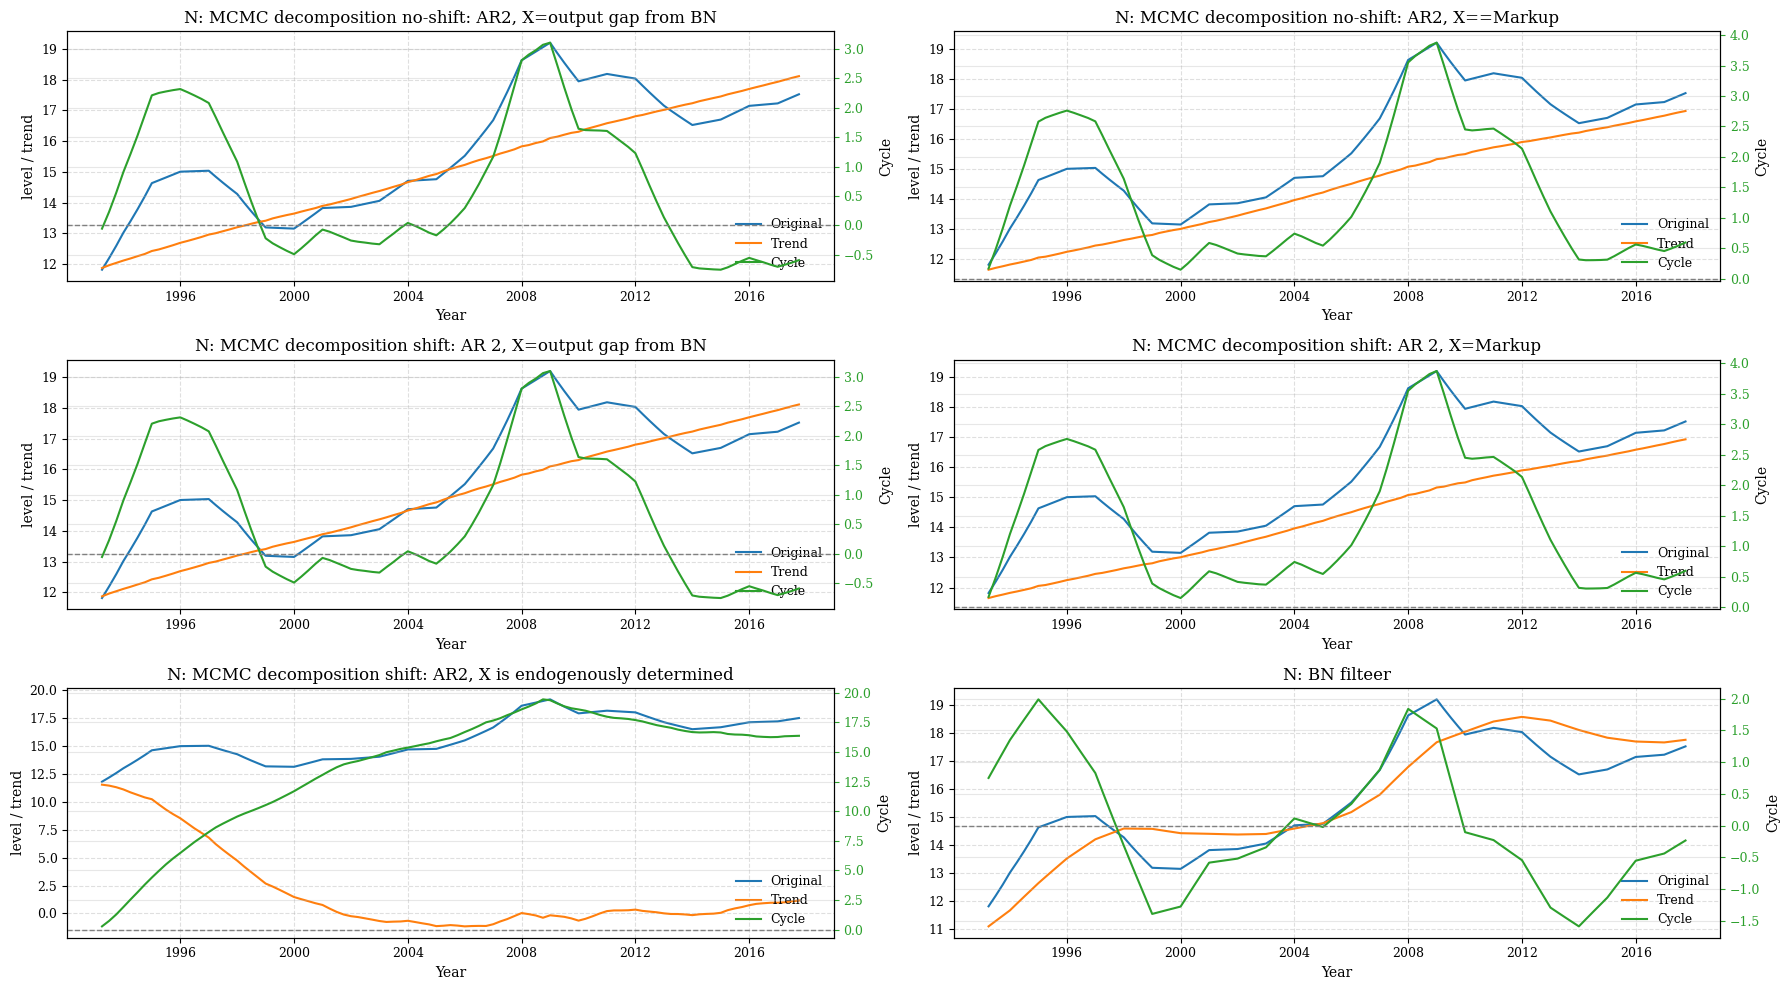

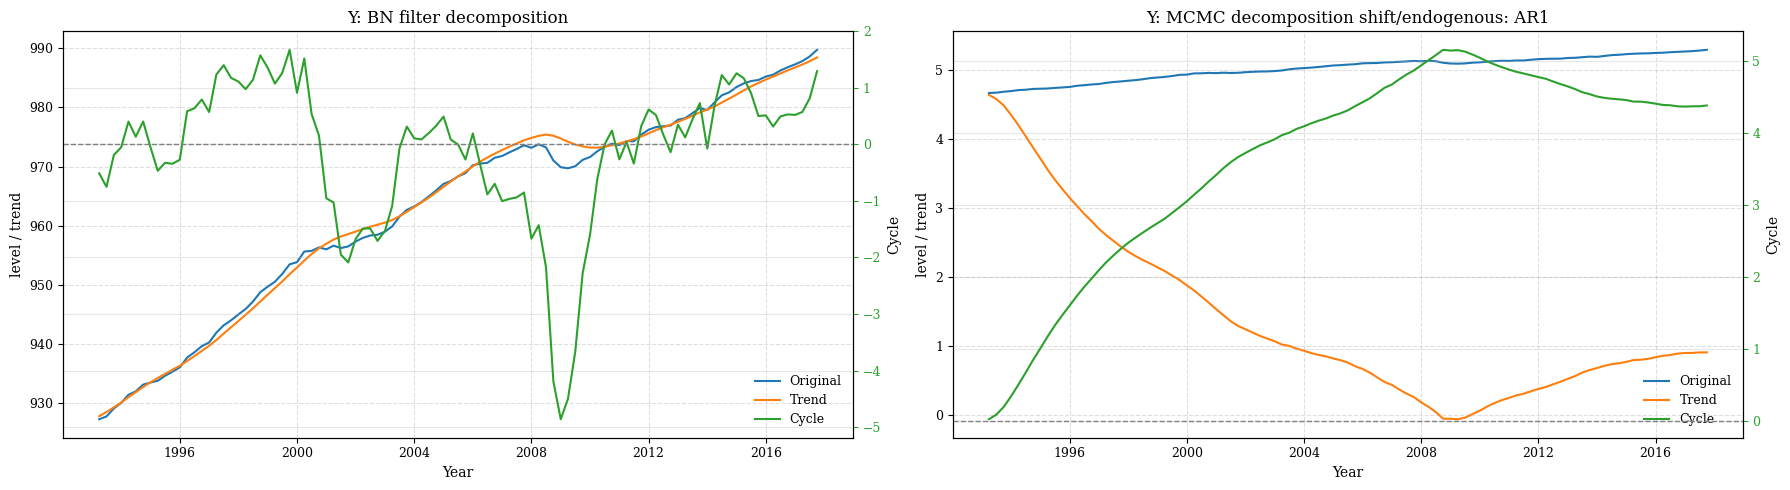

In [ ]:
# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)

# --------------------------------------------------------
# Model
# --------------------------------------------------------
scale = 5
fig, axes = plt.subplots(3, 2,
                         figsize=(1.8 * scale * 2, 1 * scale * 2),
                         sharex=False)
plot_decomposition_ax(
    axes[0, 0],
    data["DATE"], data["N"], N_bar_mean_1_bn, N_hat_mean_1_bn,
    "N: MCMC decomposition no-shift: AR2, X=output gap from BN", loc="lower right"
)
plot_decomposition_ax(
    axes[1, 0],
    data["DATE"], data["N"], N_bar_mean_2_bn, N_hat_mean_2_bn,
    "N: MCMC decomposition shift: AR 2, X=output gap from BN", loc="lower right"
)
plot_decomposition_ax(
    axes[0, 1],
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift: AR2, X==Markup", loc="lower right"
)
plot_decomposition_ax(
    axes[1, 1],
    data["DATE"], data["N"], N_bar_mean_2_m, N_hat_mean_2_m,
    "N: MCMC decomposition shift: AR 2, X=Markup", loc="lower right"
)
plot_decomposition_ax(
    axes[2, 0],
    data["DATE"], data["N"], N_bar_mean_3, N_hat_mean_3,
    "N: MCMC decomposition shift: AR2, X is endogenously determined", loc="lower right"
)
plot_decomposition_ax(
    axes[2, 1],
    data["DATE"], data["N"], data["N_trend_BN"], data["N_hat_BN"],
    "N: BN filteer", loc="lower right"
)
plt.tight_layout()
plt.show()


# --------------------------------------------------------
# 2×1 figure
# --------------------------------------------------------
scale = 5
fig, axes = plt.subplots(1, 2,
                         figsize=(1.8 * scale * 2, 1 * scale * 1),
                         sharex=False)

plot_decomposition_ax(
    axes[0],
    data["DATE"], data["output_BN"], data["output_trend_BN"], data["output_gap_BN"],
    "Y: BN filter decomposition", loc="lower right"
)

plot_decomposition_ax(
    axes[1],
    data["DATE"], data["output"], Y_bar_mean_3, x_mean_3,
    "Y: MCMC decomposition shift/endogenous: AR1", loc="lower right"
)
plt.tight_layout()

---
# Model with z


$$
    \pi_t = \alpha \pi_{{t-1}} + (1-\alpha) E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + v_t
$$
where
$$N_{t}=\bar{N}_t+\hat{N}_t$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_x x_{{t-1}}  + e_t
$$
$$\hat{N}_t = \rho_1 \hat{N}_{{t-1}} +  \rho_2 \hat{N}_{{t-2}} + u_t$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + \epsilon_t$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2),  \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$

---

In [ ]:
def model_1_z(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()

    # --- NKPC ---
    alpha  = numpyro.sample("alpha",  priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])

    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_x  = numpyro.sample("theta_x",  priors["theta_x"])

    # --- N trend / cycle ---
    bar_n   = numpyro.sample("n", priors["n"])
    rho = numpyro.sample("rho", dist.Beta(3, 2))  # rho for AR2
    phi = numpyro.sample("phi", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * rho * jnp.cos(jnp.pi * phi)
    rho_2 = -rho ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 0.1))   # t=-1
    z_init   = numpyro.sample("z_init", priors["z_init"])

    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])

    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, hat_prev1, hat_prev2, t = carry
        # --- trend ---
        Nbar_t = numpyro.sample("Nbar", dist.Normal(bar_prev + bar_n, sigma_eps))
        # --- cycle (AR2) ---
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(rho_1 * hat_prev1 + rho_2 * hat_prev2, sigma_u), obs=N_hat_obs)
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * Nhat_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_x * x_prev[t],
                        sigma_e)
        )
        # --- observation equation ---
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        return (z_t, Nbar_t, Nhat_t, hat_prev1, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, 0), timesteps)

Model with z / shift in the slope
$$
    \pi_t = \alpha \pi_{{t-1}} + (1-\alpha) E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t
$$
where
$$N_{t}=\bar{N}_t+\hat{N}_t$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_x \hat{x}_{{t-1}}  + e_t
$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + u_t$$
$$\hat{N}_t = \rho_1 \hat{N}_{{t-1}} +  \rho_2 \hat{N}_{{t-2}} + v_t$$

$$
\kappa_{t}=\eta\kappa_{t-1}-\psi\bar{N}_{t}+\mu_{t}
$$
$$
\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),  \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

In [ ]:
def model_2_z(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()
    # --- NKPC ---
    alpha  = numpyro.sample("alpha",  priors["alpha"])
    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_x  = numpyro.sample("theta_x",  priors["theta_x"])

    # --- kappa ---
    eta  = numpyro.sample("eta", priors["eta"])
    psi  = numpyro.sample("psi", priors["psi"])
    # --- N trend / cycle ---
    bar_n   = numpyro.sample("n", priors["n"])
    rho = numpyro.sample("rho", dist.Beta(3, 2))  # rho for AR2
    phi = numpyro.sample("phi", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * rho * jnp.cos(jnp.pi * phi)
    rho_2 = -rho ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 0.1))   # t=-1
    z_init   = numpyro.sample("z_init", priors["z_init"])
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_mu  = numpyro.sample("sigma_mu", priors["sigma_mu"])
    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, hat_prev1, hat_prev2, kappa_prev, t = carry
        # --- trend ---
        Nbar_t = numpyro.sample("Nbar", dist.Normal(bar_prev + bar_n, sigma_eps))
        # --- cycle (AR2) ---
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(rho_1 * hat_prev1 + rho_2 * hat_prev2, sigma_u), obs=N_hat_obs)
        # --- kappa --- 
        kappa_t = numpyro.sample(f"kappa", dist.Normal(eta * kappa_prev - psi * Nbar_t, sigma_mu))
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * Nhat_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_x * x_prev[t],
                        sigma_e)
        )
        # --- observation equation ---
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        return (z_t, Nbar_t, Nhat_t, hat_prev1, kappa_t, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, kappa_0, 0), timesteps)

---
## $x_t=\text{Markup}$
---

In [ ]:
# RUN MCMC
kernel = NUTS(model_1_z, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup, x_prev=x_markup_prev, N = N, l=len(pi))
idata_1_m_z = az.from_numpyro(mcmc)


# HSA NKPC
kernel = NUTS(model_2_z, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup,x_prev=x_markup_prev, N=N, l=len(pi))
idata_2_m_z = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [02:38<00:00, 157.79it/s, 511 steps of size 8.99e-03. acc. prob=0.99] 


In [ ]:
# Results
posterior_samples = mcmc.get_samples()
model_1_alpha_m_z = posterior_samples["alpha"].mean()
model_1_kappa_m_z = posterior_samples["kappa"].mean()
model_1_rho_1_m_z = posterior_samples["rho_1"].mean()
model_1_rho_2_m_z = posterior_samples["rho_2"].mean()
model_1_theta_N_m_z = posterior_samples["theta_N"].mean()
model_1_theta_z_m_z = posterior_samples["theta_z"].mean()
model_1_theta_pi_m_z = posterior_samples["theta_pi"].mean()
model_1_theta_x_m_z = posterior_samples["theta_x"].mean()
model_1_n_m_z = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_m_z = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m_z = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m_z = N_bar_mean_1_m_z - 1.97 * N_bar_std_1_m_z
N_bar_upper_1_m_z = N_bar_mean_1_m_z + 1.97 * N_bar_std_1_m_z
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_m_z = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m_z = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m_z = N_hat_mean_1_m_z - 1.97 * N_hat_std_1_m_z
N_hat_upper_1_m_z = N_hat_mean_1_m_z + 1.97 * N_hat_std_1_m_z

diverging  = idata_1_m_z.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

Model 1 : divergence ratio = 0.0000%


In [ ]:
# Results
posterior_samples = mcmc.get_samples()
model_2_m_alpha_z = posterior_samples["alpha"].mean()

model_2_m_rho_1_z = posterior_samples["rho_1"].mean()
model_2_m_rho_2_z = posterior_samples["rho_2"].mean()

model_2_m_theta_N_z = posterior_samples["theta_N"].mean()
model_2_m_theta_z_z = posterior_samples["theta_z"].mean()
model_2_m_theta_pi_z = posterior_samples["theta_pi"].mean()
model_2_m_theta_x_z = posterior_samples["theta_x"].mean()

model_2_m_n_z = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_m_z = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m_z = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m_z = N_bar_mean_2_m_z - 1.97 * N_bar_std_2_m_z
N_bar_upper_2_m_z = N_bar_mean_2_m_z + 1.97 * N_bar_std_2_m_z
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_m_z = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m_z = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m_z = N_hat_mean_2_m_z - 1.97 * N_hat_std_2_m_z
N_hat_upper_2_m_z = N_hat_mean_2_m_z + 1.97 * N_hat_std_2_m_z
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_m_z = np.mean(kappa_samples, axis=0) 
kappa_std_2_m_z = np.std(kappa_samples, axis=0)  
kappa_lower_2_m_z = kappa_mean_2_m_z - 1.97 * kappa_std_2_m_z
kappa_upper_2_m_z = kappa_mean_2_m_z + 1.97 * kappa_std_2_m_z

diverging  = idata_2_m_z.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

Model 2 : divergence ratio = 0.0000%


---
## $x_t=\text{Output gap from BN filter}$
---

In [ ]:
# RUN MCMC
kernel = NUTS(model_1_z, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_outputgap, x_prev=x_output_gap_prev, N = N, l=len(pi))
idata_1_bn_z = az.from_numpyro(mcmc)

# HSA NKPC
kernel = NUTS(model_2_z, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x_outputgap,x_prev=x_output_gap_prev, N=N, l=len(pi))
idata_2_bn_z = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [04:04<00:00, 102.22it/s, 1023 steps of size 5.70e-03. acc. prob=1.00]


In [ ]:

# Results
posterior_samples = mcmc.get_samples()
model_1_bn_alpha_z = posterior_samples["alpha"].mean()
model_1_bn_kappa_z = posterior_samples["kappa"].mean()
model_1_bn_theta_N_z = posterior_samples["theta_N"].mean()
model_1_bn_theta_z_z = posterior_samples["theta_z"].mean()
model_1_bn_theta_pi_z = posterior_samples["theta_pi"].mean()
model_1_bn_theta_x_z = posterior_samples["theta_x"].mean()
model_1_bn_rho_1_z = posterior_samples["rho_1"].mean()
model_1_bn_rho_2_z = posterior_samples["rho_2"].mean()
model_1_bn_n_z = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_bn_z = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_bn_z = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_bn_z = N_bar_mean_1_bn_z - 1.97 * N_bar_std_1_bn_z
N_bar_upper_1_bn_z = N_bar_mean_1_bn_z + 1.97 * N_bar_std_1_bn_z
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_bn_z = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_bn_z = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_bn_z = N_hat_mean_1_bn_z - 1.97 * N_hat_std_1_bn_z
N_hat_upper_1_bn_z = N_hat_mean_1_bn_z + 1.97 * N_hat_std_1_bn_z

diverging  = idata_1_bn.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

Model 1 : divergence ratio = 0.0000%


In [ ]:

# Results
posterior_samples = mcmc.get_samples()
model_2_bn_alpha_z = posterior_samples["alpha"].mean()
model_2_bn_theta_N_z = posterior_samples["theta_N"].mean()
model_2_bn_theta_z_z = posterior_samples["theta_z"].mean()
model_2_bn_theta_pi_z = posterior_samples["theta_pi"].mean()
model_2_bn_theta_x_z = posterior_samples["theta_x"].mean()
model_2_bn_rho_1_z = posterior_samples["rho_1"].mean()
model_2_bn_rho_2_z = posterior_samples["rho_2"].mean()
model_2_bn_n_z = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_bn_z = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_bn_z = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_bn_z = N_bar_mean_2_bn_z - 1.97 * N_bar_std_2_bn_z
N_bar_upper_2_bn_z = N_bar_mean_2_bn_z + 1.97 * N_bar_std_2_bn_z
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_bn_z = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_bn_z = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_bn_z = N_hat_mean_2_bn_z - 1.97 * N_hat_std_2_bn_z
N_hat_upper_2_bn_z = N_hat_mean_2_bn_z + 1.97 * N_hat_std_2_bn_z
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_bn_z = np.mean(kappa_samples, axis=0) 
kappa_std_2_bn_z = np.std(kappa_samples, axis=0)  
kappa_lower_2_bn_z = kappa_mean_2_bn_z - 1.97 * kappa_std_2_bn_z
kappa_upper_2_bn_z = kappa_mean_2_bn_z + 1.97 * kappa_std_2_bn_z

diverging  = idata_2_bn_z.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

Model 2 : divergence ratio = 0.0000%


---

## Endogenously determined output gap

---

endogenously determined output gap
$$
    \pi_t = \alpha \pi_{{t-1}} + (1-\alpha) E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t
$$
where
$$N_{t}=\bar{N}_t+\hat{N}_t$$
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_x x_{{t-1}}  + \eta_t
$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + u_t$$
$$\hat{N}_t = \rho_1 \hat{N}_{{t-1}} +  \rho_2 \hat{N}_{{t-2}} + v_t$$

$$
\bar{y}_{t}=g+\bar{y}_{t-1}+\chi_{t}.
$$
$$
x_{t}=\nu_1 x_{t-1} + \nu_2 x_{t-2},
$$

$$
\kappa_{t}=\eta\kappa_{t-1}-\psi\bar{N}_{t}+\mu_{t},
$$

$$
\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),  \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$


In [ ]:
def model_3_z(pi, pi_prev, pi_expect, Y,  N, l):
    priors = set_prior_distributions()
    # --- NKPC ---
    alpha  = numpyro.sample("alpha",  priors["alpha"])
    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_x  = numpyro.sample("theta_x",  priors["theta_x"])
    # --- Y trend / cycle ---
    rho_y = numpyro.sample("rho_y", dist.Beta(3, 2))  # rho for AR2
    phi_y = numpyro.sample("phi_y", dist.Uniform(0.1, 0.9))  # phi for AR2
    nu_1 = 2 * rho_y * jnp.cos(jnp.pi * phi_y)
    nu_2 = -rho_y ** 2
    numpyro.deterministic("nu_1", nu_1) # Nhat AR1 coeff
    numpyro.deterministic("nu_2", nu_2) # Nhat AR2 coeff

    # --- kappa ---
    eta  = numpyro.sample("eta", priors["eta"])
    psi  = numpyro.sample("psi", priors["psi"])
    # --- N trend / cycle ---
    bar_n   = numpyro.sample("n", priors["n"])
    g = numpyro.sample("g", priors["g"])  # Ybar trend
    rho = numpyro.sample("rho", dist.Beta(3, 2))  # rho for AR2
    phi = numpyro.sample("phi", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * rho * jnp.cos(jnp.pi * phi)
    rho_2 = -rho ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 0.1))   # t=-1
    Ybar_0  = numpyro.sample("Ybar_0", dist.Normal(Y[0], 1))  # Ybar init
    x_0 = numpyro.sample("x_0", dist.Normal(0, 0.1))  # Y init
    x_1 = numpyro.sample("x_1", dist.Normal(0, 0.1))  # Y_{t-1} init
    z_init   = numpyro.sample("z_init", priors["z_init"])
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_mu  = numpyro.sample("sigma_mu", priors["sigma_mu"])
    sigma_omega = numpyro.sample("sigma_omega", priors["sigma_omega"])
    sigma_chi = numpyro.sample("sigma_chi", priors["sigma_chi"])

    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, Nhat_prev1, Nhat_prev2, kappa_prev, Ybar_prev, xhat_prev1, xhat_prev2,  t = carry
        # --- trend ---
        Nbar_t = numpyro.sample("Nbar", dist.Normal(bar_prev + bar_n, sigma_eps))
        # --- cycle (AR2) ---
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(rho_1 * Nhat_prev1 + rho_2 * Nhat_prev2, sigma_u), obs=N_hat_obs)
        # --- kappa --- 
        kappa_t = numpyro.sample(f"kappa", dist.Normal(eta * kappa_prev - psi * Nbar_t, sigma_mu))
        Ybar_t = numpyro.sample("Ybar", dist.Normal(Ybar_prev + g, sigma_chi))
        x_hat_obs = Y[t] - Ybar_t
        numpyro.deterministic("xhat", x_hat_obs)  # for observation
        xhat_t = numpyro.sample(
            "xhat_t",
            dist.Normal(nu_1 * xhat_prev1 + nu_2 * xhat_prev2, sigma_omega),
            obs=Y[t] - Ybar_t
        )
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * Nhat_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_x * xhat_prev1,
                        sigma_e)
        )
        # --- observation equation ---
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * xhat_t - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        return (z_t, Nbar_t, Nhat_t, Nhat_prev1, kappa_t, Ybar_t, xhat_t, xhat_prev1, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, kappa_0, Ybar_0, x_0, x_1, 0), timesteps)

In [ ]:
# RUN MCMC
kernel = NUTS(model_3_z, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y = Y, N=N, l=len(pi))
idata_3_z = az.from_numpyro(mcmc)

sample: 100%|██████████| 25000/25000 [07:17<00:00, 57.20it/s, 1023 steps of size 1.36e-05. acc. prob=0.99]


In [ ]:
# Results
posterior_samples = mcmc.get_samples()
model_3_alpha_z = posterior_samples["alpha"].mean()
model_3_theta_N_z = posterior_samples["theta_N"].mean()
model_3_theta_z_z = posterior_samples["theta_z"].mean()
model_3_theta_pi_z = posterior_samples["theta_pi"].mean() 
model_3_theta_x_z = posterior_samples["theta_x"].mean() 
model_3_rho_1_z = posterior_samples["rho_1"].mean()
model_3_rho_2_z = posterior_samples["rho_2"].mean()
model_3_nu_1_z = posterior_samples["nu_1"].mean()
model_3_nu_2_z = posterior_samples["nu_2"].mean()
model_3_n_z = posterior_samples["n"].mean()

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_3_z = np.mean(N_bar_samples, axis=0) 
N_bar_std_3_z = np.std(N_bar_samples, axis=0)  
N_bar_lower_3_z = N_bar_mean_3_z - 1.97 * N_bar_std_3_z
N_bar_upper_3_z = N_bar_mean_3_z + 1.97 * N_bar_std_3_z
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_3_z = np.mean(N_hat_samples, axis=0) 
N_hat_std_3_z = np.std(N_hat_samples, axis=0)  
N_hat_lower_3_z = N_hat_mean_3_z - 1.97 * N_hat_std_3_z
N_hat_upper_3_z = N_hat_mean_3_z + 1.97 * N_hat_std_3_z
kappa_samples = posterior_samples["kappa"]
kappa_mean_3_z = np.mean(kappa_samples, axis=0) 
kappa_std_3_z = np.std(kappa_samples, axis=0)  
kappa_lower_3_z = kappa_mean_3_z - 1.97 * kappa_std_3_z
kappa_upper_3_z = kappa_mean_3_z + 1.97 * kappa_std_3_z
Y_bar_samples = posterior_samples["Ybar"]
Y_bar_mean_3_z = np.mean(Y_bar_samples, axis=0) 
Y_bar_std_3_z = np.std(Y_bar_samples, axis=0)  
Y_bar_lower_3_z = Y_bar_mean_3_z - 1.97 * Y_bar_std_3_z
Y_bar_upper_3_z = Y_bar_mean_3_z + 1.97 * Y_bar_std_3_z
x_samples = posterior_samples["xhat"]
x_mean_3_z = np.mean(x_samples, axis=0) 
x_std_3_z = np.std(x_samples, axis=0)  
x_lower_3_z = x_mean_3_z - 1.97 * x_std_3_z
x_upper_3_z = x_mean_3_z + 1.97 * x_std_3_z

diverging  = idata_3_z.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 3 : divergence ratio = {ratio_div:.4%}")

Model 3 : divergence ratio = 0.1000%


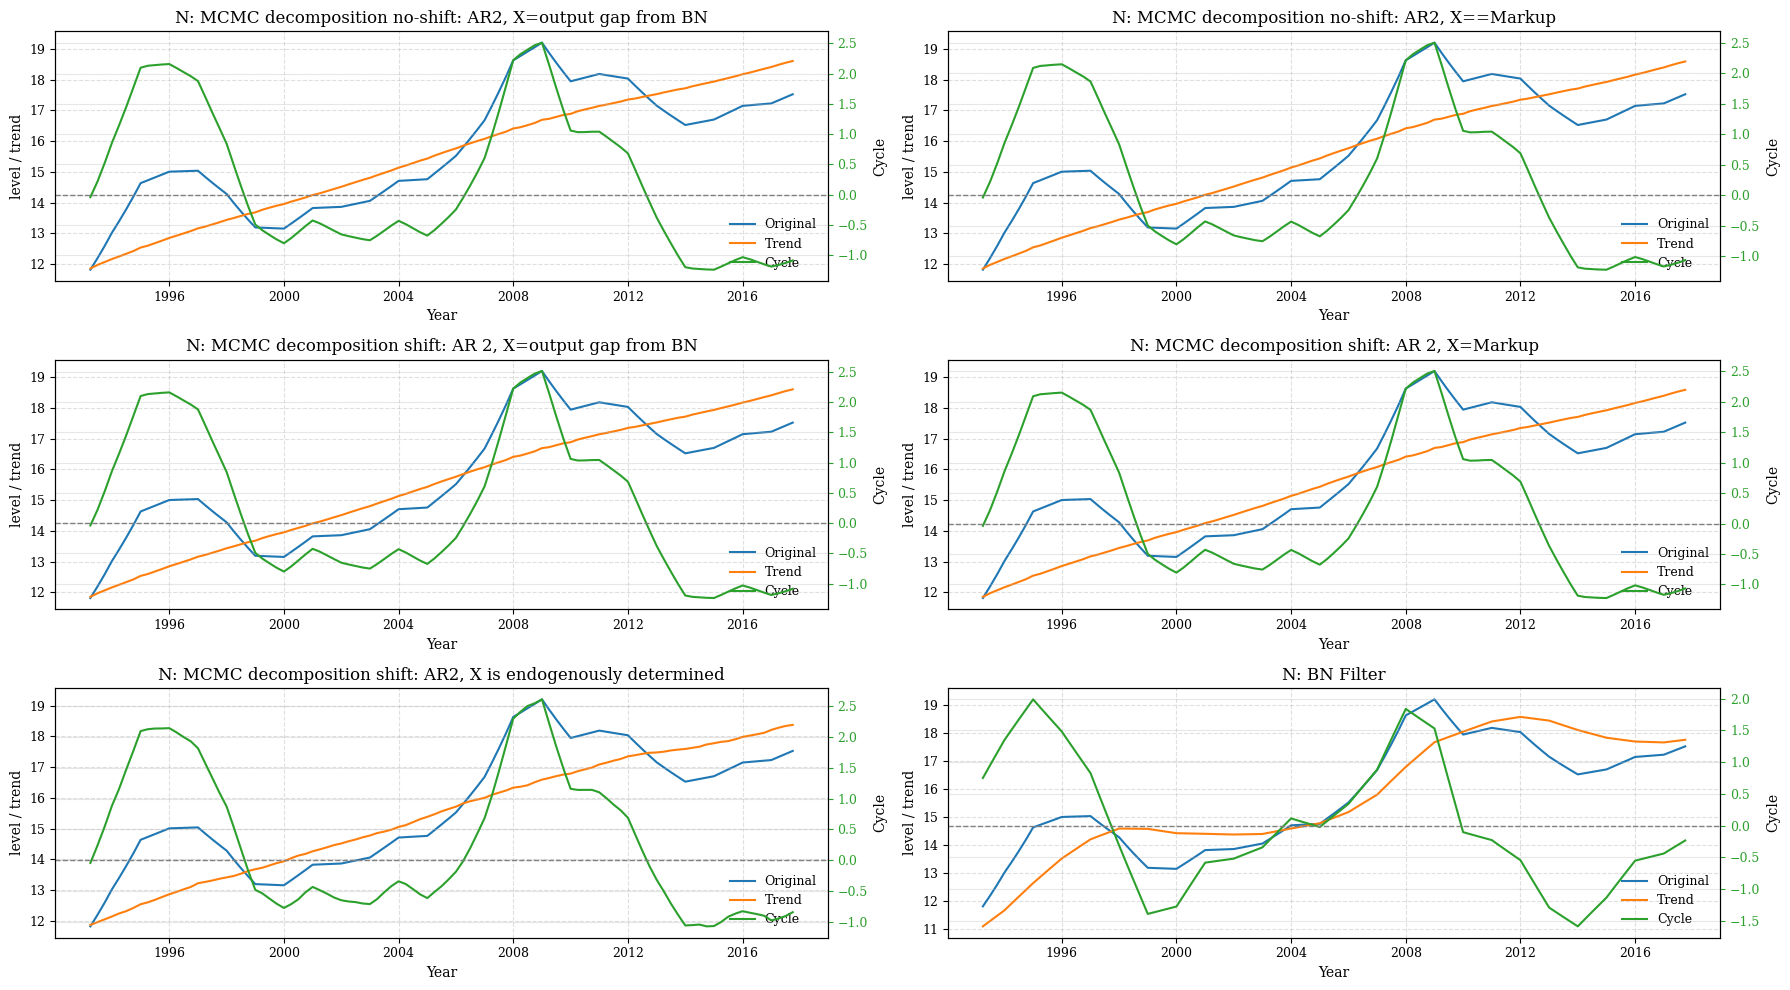

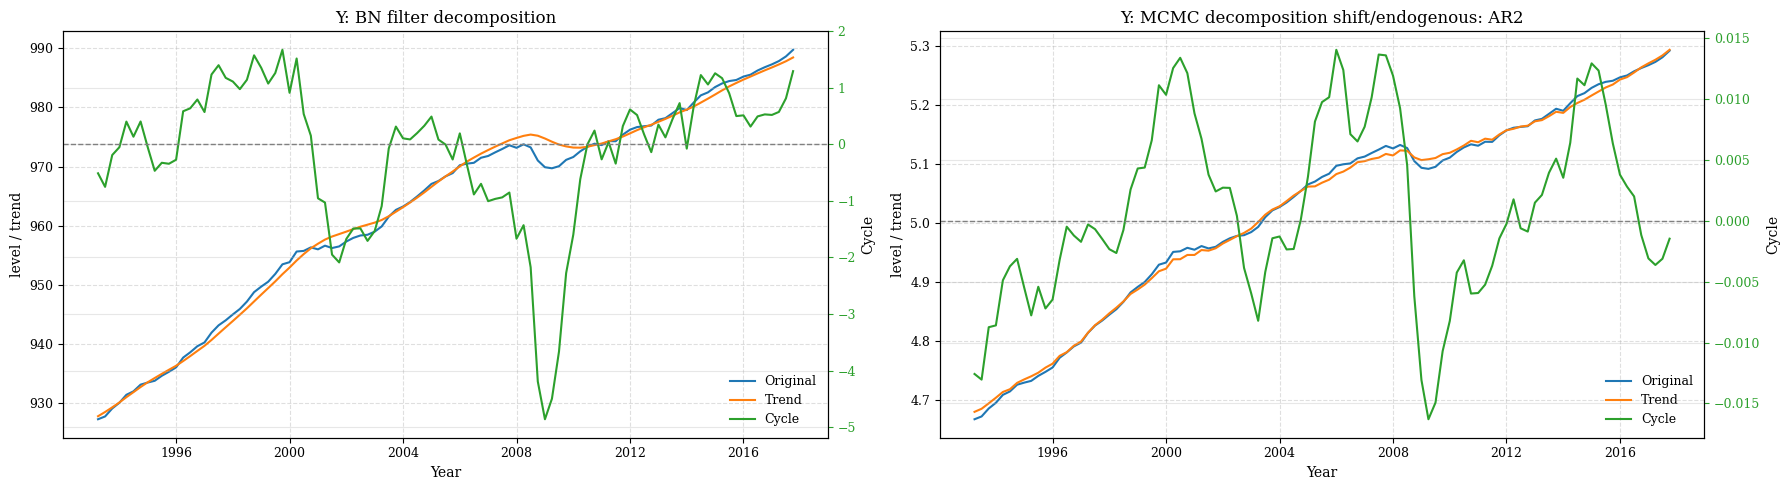

In [ ]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)

# --------------------------------------------------------
# Model
# --------------------------------------------------------
scale = 5
fig, axes = plt.subplots(3, 2,
                         figsize=(1.8 * scale * 2, 1 * scale * 2),
                         sharex=False)
plot_decomposition_ax(
    axes[0, 0],
    data["DATE"], data["N"], N_bar_mean_1_bn_z, N_hat_mean_1_bn_z,
    "N: MCMC decomposition no-shift: AR2, X=output gap from BN", loc="lower right"
)
plot_decomposition_ax(
    axes[1, 0],
    data["DATE"], data["N"], N_bar_mean_2_bn_z, N_hat_mean_2_bn_z,
    "N: MCMC decomposition shift: AR 2, X=output gap from BN", loc="lower right"
)
plot_decomposition_ax(
    axes[0, 1],
    data["DATE"], data["N"], N_bar_mean_1_m_z, N_hat_mean_1_m_z,
    "N: MCMC decomposition no-shift: AR2, X==Markup", loc="lower right"
)
plot_decomposition_ax(
    axes[1, 1],
    data["DATE"], data["N"], N_bar_mean_2_m_z, N_hat_mean_2_m_z,
    "N: MCMC decomposition shift: AR 2, X=Markup", loc="lower right"
)
plot_decomposition_ax(
    axes[2, 0],
    data["DATE"], data["N"], N_bar_mean_3_z, N_hat_mean_3_z,
    "N: MCMC decomposition shift: AR2, X is endogenously determined", loc="lower right"
)
plot_decomposition_ax(
    axes[2, 1],
    data["DATE"], data["N"], data["N_trend_BN"], data["N_hat_BN"],
    "N: BN Filter", loc="lower right"
)

plt.tight_layout()
plt.show()


# --------------------------------------------------------
# 2×1 figure
# --------------------------------------------------------
scale = 5
fig, axes = plt.subplots(1, 2,
                         figsize=(1.8 * scale * 2, 1 * scale * 1),
                         sharex=False)

plot_decomposition_ax(
    axes[0],
    data["DATE"], data["output_BN"], data["output_trend_BN"], data["output_gap_BN"],
    "Y: BN filter decomposition", loc="lower right"
)

plot_decomposition_ax(
    axes[1],
    data["DATE"], data["output"], Y_bar_mean_3_z, x_mean_3_z,
    "Y: MCMC decomposition shift/endogenous: AR2", loc="lower right"
)
plt.tight_layout()

In [ ]:
dict_idata = {'Normal NKPC/ output gap':idata_0_bn, 'Normal NKPC/ markup':idata_0_m, 
            #   'HSA NKPC no-shift/output gap':idata_1_bn, 'HSA NKPC no-shift/markup':idata_1_m,
            #   'HSA NKPC shift/output gap':idata_2_bn, 'HSA NKPC shift/markup':idata_2_m,
            #   'HSA NKPC shift/endogenous': idata_3,
              'HSA NKPC no-shift/output gap with z':idata_1_bn_z, 'HSA NKPC no-shift/markup with z':idata_1_m_z,
              'HSA NKPC shift/output gap with z':idata_2_bn_z, 'HSA NKPC shift/markup with z':idata_2_m_z,
              'HSA NKPC shift/endogenous with z': idata_3_z}

params = [
    # "alpha", "kappa", "theta", "theta_N", "theta_pi", "theta_x", "rho_1","rho_2", "eta", "psi", "nu_1", "nu_2", "n", "g",
    "alpha", "kappa", "theta", "delta", "phi", "theta_N", "theta_pi", "theta_x", "rho_1","rho_2", "eta", "psi", "beta", "nu_1", "nu_2", "n", "g",
    # "sigma_v", "sigma_u", "sigma_eps", "sigma_omega", "sigma_chi", "sigma_mu"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)


params = [
    # "alpha", "kappa", "theta", "phi", "delta", "rho_1","rho_2", "eta", "psi", "sigma", "beta", "nu_1", "nu_2", "n", "g",
    "sigma_v", "sigma_u", "sigma_eps", "sigma_omega", "sigma_chi", "sigma_mu"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)


NameError: name 'idata_0_bn' is not defined

In [ ]:
# tables = {
#     "posterior_means"   : summary_df,
# }

# for name, df in tables.items():
#     latex_code = df.to_latex(index=False, escape=False)
#     display(Markdown(f"### {name}\n```latex\n{latex_code}\n```"))

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

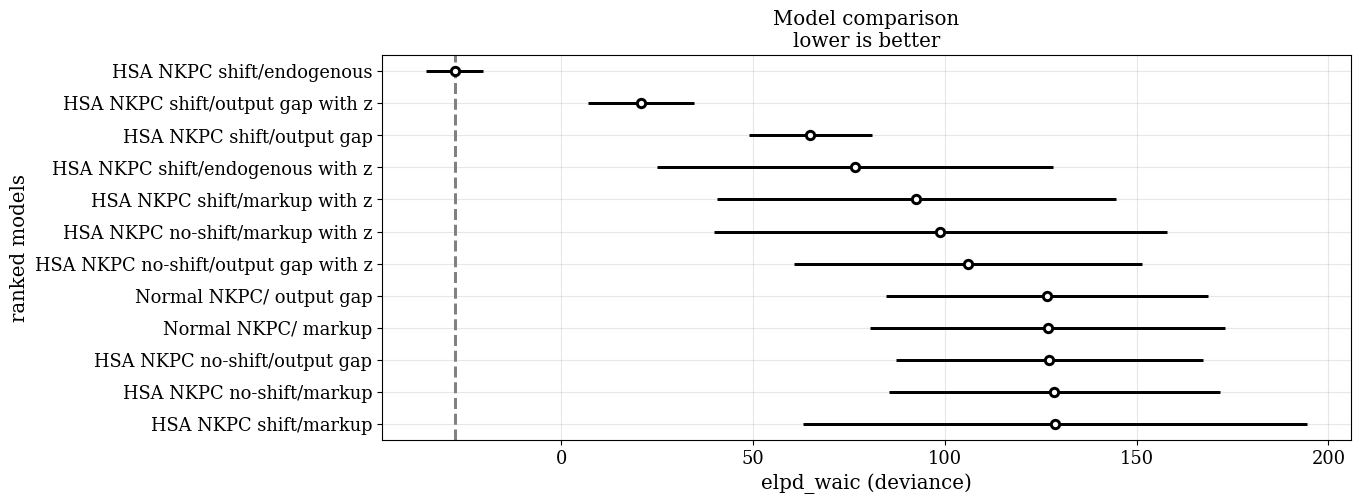

In [ ]:
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
scale = 5  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))

# In-sample Fit

In [ ]:
# tables = {
#     "posterior_means"   : summary_df,
#     "variance_core"     : var,
#     "variance_z"        : z_var,
#     "corr_NY"           : coeff,
#     "corr_zY"           : coeff_zY,
#     "corr_zN"           : coeff_zN,
#     "loo_compare_dev"   : df_loo_dev
# }

# for name, df in tables.items():
#     latex_code = df.to_latex(index=False, escape=False)
#     display(Markdown(f"### {name}\n```latex\n{latex_code}\n```"))

## $\kappa_t$


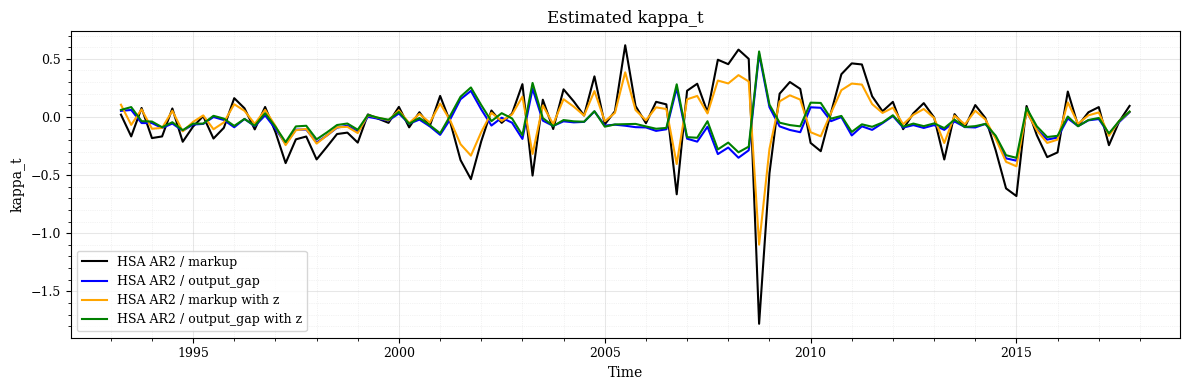

In [ ]:

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2_m, label="HSA AR2 / markup", color=colors[0])
plt.plot(data["DATE"], kappa_mean_2_bn, label="HSA AR2 / output_gap", color=colors[1])
plt.plot(data["DATE"], kappa_mean_2_m_z, label="HSA AR2 / markup with z", color=colors[2])
plt.plot(data["DATE"], kappa_mean_2_bn_z, label="HSA AR2 / output_gap with z", color=colors[3])
plt.title("Estimated kappa_t")
plt.xlabel("Time")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()